In [1]:
import numpy as np
from scipy.special import erf, erfinv
from scipy.sparse import issparse
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 3, 3
N_HVC = N_syl * N_HVC_per_syl

In [3]:
PEAK_RATE, KERNEL_WIDTH = 150, 20

In [4]:
T_rend = 600 # Each rendition
N_rend = 60 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

(3, 600)


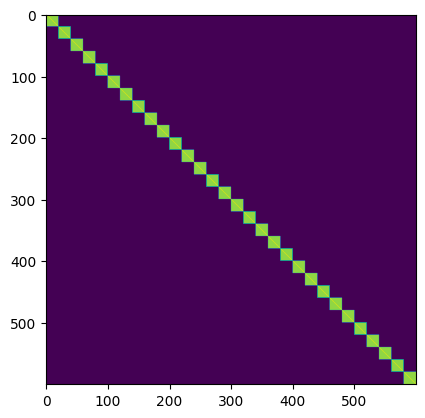

In [5]:
# Syllables and time stamps
# syl = rng.normal(1, 3, size=(N_syl, NE))#.clip(min=0)
N_shared_channels = 20
syl_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
plt.imshow(syl_cov)
syl = rng.multivariate_normal(np.ones(NE), syl_cov, size=N_syl)
print(syl.shape)

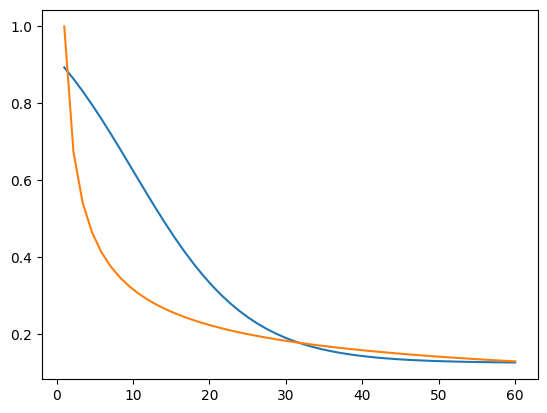

In [6]:
_ = np.linspace(1, N_rend)
plt.plot(_, (np.tanh(-(_-10)/15)+1.25)/2)
plt.plot(_, np.power(_, -0.5))

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'HVC rates (Hz)')]

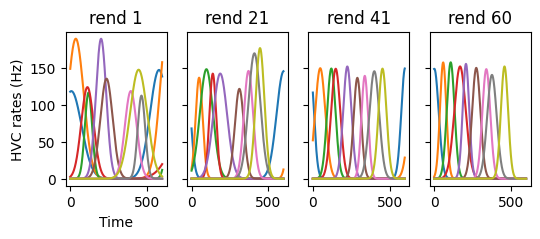

In [7]:
tsyl_start, tsyl_end, burst_ts = generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)
save_W_ts = np.round(tsyl_end[-1]).astype(int)
peak_rate = np.zeros_like(burst_ts)
kernel_width = np.zeros_like(burst_ts) + KERNEL_WIDTH
for i in range(N_rend):
    j = (np.tanh(-(i-10)/15)+1.25)/2
    burst_ts[:,i] += rng.normal(loc=0, scale=80*j, size=9)
    peak_rate[:,i] = lognormal_gen(rng, PEAK_RATE, 50*j, size=9)
    kernel_width[:,i] += rng.exponential(40*j, size=9)
rH = generate_HVC(T, burst_ts, peak_rate, kernel_width)

js = (0, int(np.floor(N_rend/3)), int(np.floor(N_rend*2/3)), N_rend-1)
fig, ax = plt.subplots(1, len(js), figsize=(6, 2), sharex='all', sharey='all')
for i, j in enumerate(js):
    ax[i].plot(rH[T_burn+j*T_rend:T_burn+(j+1)*T_rend])
    ax[i].set_title(f'rend {j+1}', fontsize=12)
ax[0].set(xlabel='Time', ylabel='HVC rates (Hz)')

In [8]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

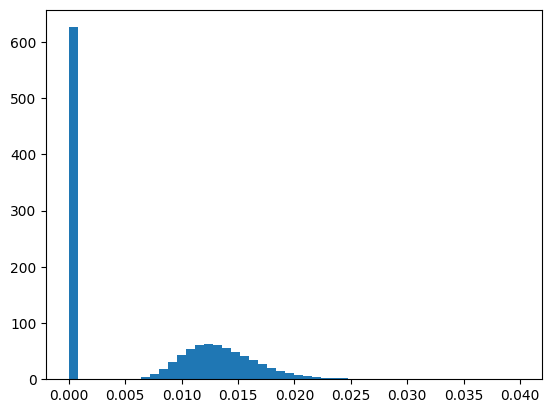

In [9]:
gen = lognormal_gen
# gen = const_gen
c = 0.5
JEE0, JEI0, JIE0, JII0 = np.array([1, 0.8, 1.5, 0.6]) / 3
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.25
# c = 1
# JEE0, JEI0, JIE0, JII0 = np.array([1, 0.8, 1.25, 0.9])
# sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.25
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=True) / np.sqrt(NE)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=True) / np.sqrt(NI)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=True) / np.sqrt(NE)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=True) / np.sqrt(NI)
J0_mean = JEE0 / np.sqrt(NE) * c
if issparse(JEE):
    plt.hist(JEE.toarray().flatten(), bins=50, density=True)
else:
    plt.hist(JEE.flatten(), bins=50, density=True)

In [10]:
rEmax, rImax, thE, thI, sE, sI = 40, 100, -5, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

In [11]:
w0_mean, w0_std, cW = 2/N_HVC, 0/N_HVC, 0.05
w_inh, wI = w0_mean*cW, 0.0
tauE, tauI, dt = 40, 10, 1

net = EINetRecPlasticity(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, 
                         JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                         w_inh=w_inh, wI=wI, w0_std=w0_std, cW=cW)

100%|███████████████████████████████████████| 999/999 [00:00<00:00, 2624.82it/s]


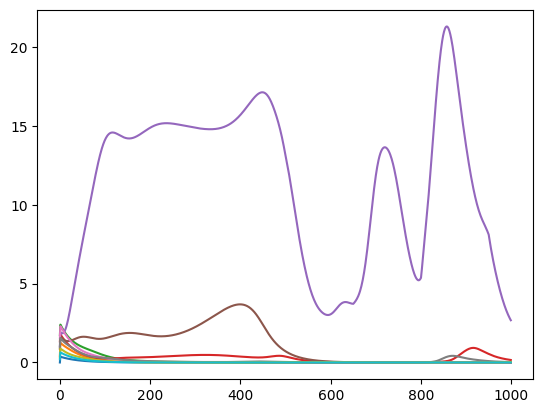

In [12]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
aux = [np.zeros_like(rH[:1000])+rH[:1000].mean(axis=1)[:,None], 
       np.zeros_like(aud[:1000])+aud[:1000].mean(axis=1)[:,None]]
_ = net.sim(rE0, rI0, *aux, [], 1000, dt, 0)
rE, rI, _, _, hE = _
plt.plot(rE[:1000,:10]);

In [13]:
from numba import njit, void, f8, i4
@njit(void(f8[:], f8[:], f8[:], i4[:], i4[:]))
def outer(out, post, pre, indptr, indices):
    for i in range(len(pre)):
        # range in .data for the i-th col
        p, q = indptr[i], indptr[i+1] 
        out[p:q] = (post[indices[p:q]] - 1) * pre[i]

def bilin_hebb(net, aiv_post, aiv_pre, hvc, lr, J0_mean, tauW):
    # lr < 0, anti-Hebbian
    #### Comment off to enable HVC->E plasticity as well ####
    # if issparse(net.W):
    #     aux = np.zeros(net.W.data.shape)
    #     outer(aux, aiv_post, hvc, net.W.indptr, net.W.indices)
    #     dW = lr * aux - (net.W.data - net.w0_mean)
    #     net.W.data = np.clip(net.W.data + dW / tauW, a_min=0, a_max=None)
    # else:
    #     aux = (aiv_post[:,None] - 1) * hvc[:,None]
    #     dW = lr * (aiv_post[:,None] - 1) * hvc[:,None] - (net.W - net.w0_mean)
    #     net.W = np.clip(net.W + dW / tauW, a_min=1e-10, a_max=None)
    ####
    if issparse(net.JEE):
        aux = np.zeros(net.JEE.data.shape)
        outer(aux, aiv_post, aiv_pre, net.JEE.indptr, net.JEE.indices)
        dW = lr * aux - (net.JEE.data - J0_mean)
        net.JEE.data = np.clip(net.JEE.data + dW / tauW, a_min=1e-10, a_max=None)
    else:
        aux = (aiv_post[:,None] - 1) * aiv_pre[None,:]
        dW = lr * aux - (net.JEE - J0_mean)
        net.JEE = np.clip(net.JEE + dW / tauW, a_min=1e-10, a_max=None)

In [14]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
_ = net.sim(rE0, rI0, rH, aud, save_W_ts, T, dt, 1, bilin_hebb,
            lr=-3e-1, asyn=10, J0_mean=J0_mean, tauW=1e5)
rE, rI, Ws, mean_HVC_input, hE = _
if issparse(Ws[0]):
    Ws = [_.toarray() for _ in Ws]

100%|███████████████████████████████████| 36499/36499 [00:34<00:00, 1063.49it/s]


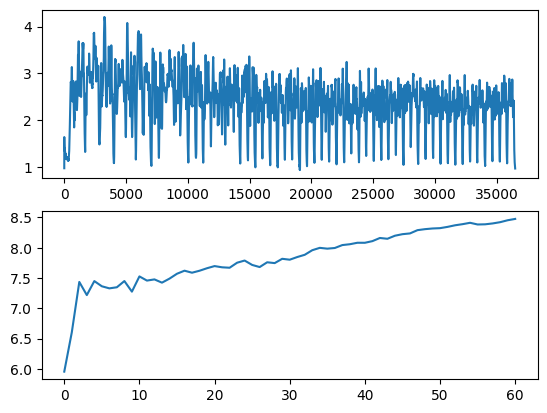

In [15]:
fig, ax = plt.subplots(2)
ax[0].plot(rE.mean(axis=-1))
ax[1].plot([np.sqrt((_**2).sum()) for _ in Ws])

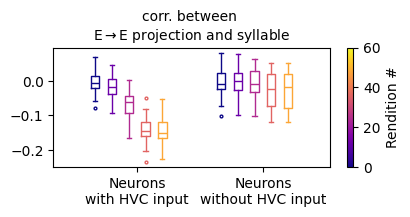

In [16]:
J_corrs = [correlation(_.T, syl) for _ in Ws]
cmap = plt.get_cmap('plasma')
p, q = 0, 1 # syl idx and hvc idx
idx = [0, 5, 10, 20, N_rend-1] # rendition idx
filt = np.where(net.W.toarray() != 0)
fig, ax = plt.subplots(1, sharey='all', figsize=(4, 2))
for i, j in enumerate(idx):
    color = cmap(i/len(idx))
    sig = J_corrs[i][filt[0][filt[1]==q],p]
    bg = J_corrs[i][~filt[0][filt[1]==q],p]
    ax.boxplot([sig, bg], positions=[i/len(idx), 1.5+i/len(idx)],
               widths=0.5/len(idx), flierprops=dict(ms=2, mec=color), 
               boxprops=dict(color=color), capprops=dict(color=color),
               whiskerprops=dict(color=color), medianprops=dict(color=color))
sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=N_rend))
fig.colorbar(sm, ax=ax, aspect=20, label='Rendition #')

ax.set(xticks=[0.5, 2], xticklabels=['Neurons\nwith HVC input', 'Neurons\nwithout HVC input'])
ax.set_title('corr. between \n' + r'E$\to$E projection and syllable', fontsize=10)
fig.tight_layout(pad=0.1)
fig.savefig('svg/EI_rec_immature_HVC_train_result.svg')

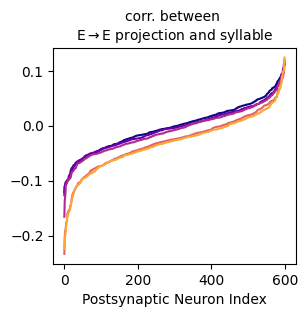

In [17]:
cmap = plt.get_cmap('plasma')
p, q = 0, 1 # syl idx and hvc idx
idx = [0, 5, 10, 20, -1]
filt = np.where(net.W.toarray() != 0)
fig, ax = plt.subplots(1, sharey='all', figsize=(3, 3))
for i, j in enumerate(idx):
    color = cmap(i/len(idx))
    ax.plot(np.sort(J_corrs[i][:,p]), c=color)
ax.set(xlabel='Postsynaptic Neuron Index')
ax.set_title('corr. between \n' + r'E$\to$E projection and syllable', fontsize=10)
fig.tight_layout(pad=0.1)

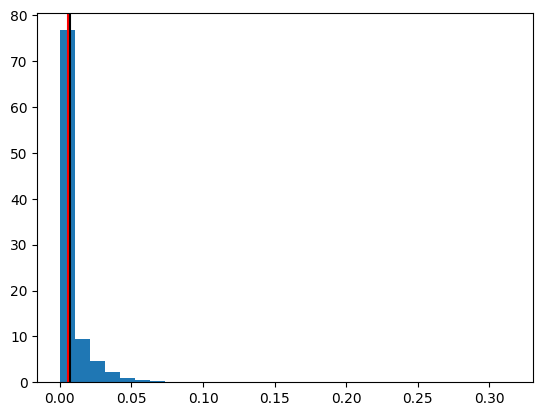

In [18]:
plt.hist(Ws[-1].flatten(), density=True, bins=30)
plt.axvline(Ws[-1].mean(), color='r')
plt.axvline(JEE.mean(), color='k')

## Test Model with Different Scenarios

In [19]:
Experiment.AUD_LIST

('correct', 'shuf_syl_idx', 'perturb', 'off')

In [20]:
rH_exp = generate_HVC(T_burn+T_rend, generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)[-1], 
                      np.zeros_like(burst_ts)+PEAK_RATE, np.zeros_like(burst_ts)+KERNEL_WIDTH)

In [21]:
exp = Experiment(net, rH_exp, syl, noise=1, T_test=T_burn+T_rend, 
                 t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
pert_mean = np.ones(NE)
pert_cov = block_sym_mat(NE, K=N_shared_channels, var=9, cov=7.5)
pert_args = [(pert_mean, pert_cov, 0)]
test_codes = ('correct', 'perturb', 'off', 'correct') # last one for playback
if_sing = (True, True, True, False)
test_names = ('Singing\ncorrect', 'Singing\nperturb',
              'Singing\ndeafen', 'Playback\n')
tests_all = exp.sim_multi(test_codes, if_sing, pert_args * len(test_codes))

100%|█████████████████████████████████████| 1099/1099 [00:00<00:00, 3677.74it/s]


In [22]:
rE_block_avgs = [block_apply(_, K=N_shared_channels, func=np.mean)
                 for _ in tests_all['rE']]
syl_block_avgs = block_apply(syl, K=N_shared_channels, func=np.mean)
bos_block_avgs = [block_apply(_, K=N_shared_channels, func=np.mean)
                 for _ in tests_all['bos']]

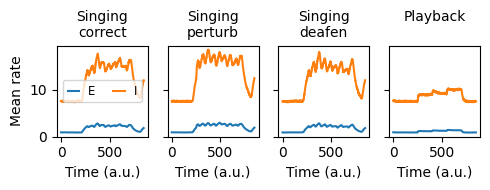

In [23]:
ti, tj = T_burn//2, T_burn+T_rend
fig, ax = plot_tests_mean(tests_all['rE'], tests_all['rI'], test_names, ti, tj)

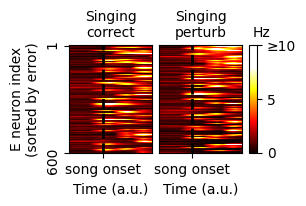

In [24]:
fig, ax = plot_raster_cmp_syl_dsyl(tests_all['rE'][0], tests_all['rE'][2], syl[0], 
                                   tests_all['bos'][2][0]-syl[0], 
                                   tsyl_start[0,0], tsyl_end[0,0], 
                                   figsize=(3, 2), plot_z=False, th=10)
fig.savefig('svg/err_response_EI_rec_immature_HVC.svg')

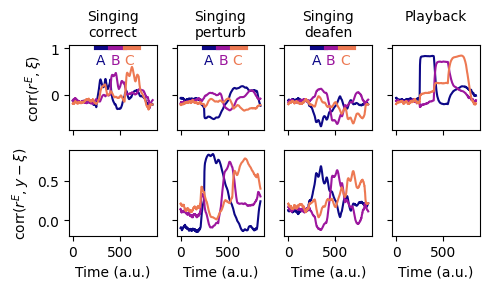

In [25]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-index-shuffled
idx = [(j, *ts[i]) for i, j in enumerate(tests_all['shuff_idx'][1])] # for index-shuffled
so = {0: aux, 1: aux, 2: aux}
fig, ax = plot_tests_corrs(rE_block_avgs, bos_block_avgs, syl_block_avgs, test_names,
                           ti, tj, tid_perturb_input=(1, 2), 
                           syl_order=so, y=1)

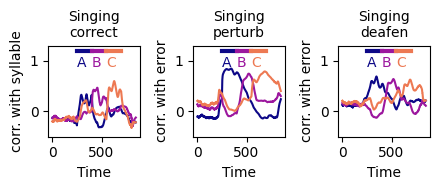

In [26]:
ti, tj = T_burn//2, T_burn + T_rend
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
aux = [(i, *ts[i]) for i in (0, 1, 2)] # for non-index-shuffled
idx = [(j, *ts[i]) for i, j in enumerate(tests_all['shuff_idx'][1])] # for index-shuffled
# Do not need to show playback
so = {0: aux, 1: aux, 2: aux}
fig, ax = plot_tests_corrs_simple(rE_block_avgs[:-1], bos_block_avgs[:-1], 
                                  syl_block_avgs, test_names[:-1],
                                  ti, tj, tid_perturb_input=(1, 2), 
                                  syl_order=so, y=1.2)
fig.savefig('svg/corr_EI_rec_immature_HVC.svg')

414 186
98 52


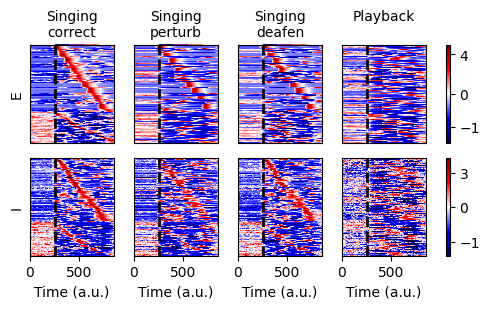

In [27]:
ti, tj = T_burn//2, T_burn + T_rend #int(tsyl_end[2,0])
fig, ax = plot_tests_raster(tests_all, test_names, 
                            ti, tj, T_burn, plot_inh=True, syl_order=so)
# fig.savefig('svg/raster_EI.svg')

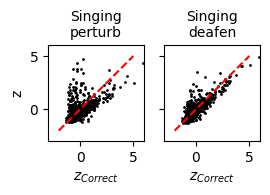

In [28]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_ctrl_vs_nonctrl(tests_all['rE'][:-1], test_names[:-1], ti, tj)
# fig, ax = plot_ctrl_vs_nonctrl(rE_block_avgs[:-1], test_names[:-1], ti, tj)
fig.savefig('svg/joint_dist_c_vs_nc_EI_rec_immature_HVC.svg')

[(-1.0, 1.0)]

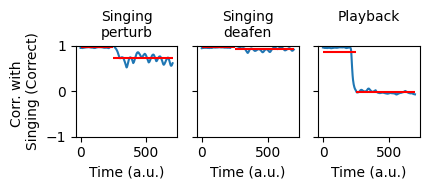

In [29]:
ti, tj = T_burn//2, int(tsyl_end[2,0])
fig, ax = plot_corr_ctrl_nonctrl(tests_all['rE'], test_names, ti, tj, T_burn)
# fig, ax = plot_corr_ctrl_nonctrl(rE_block_avgs, test_names, ti, tj, T_burn)
ax[0].set(ylim=[-1, 1])

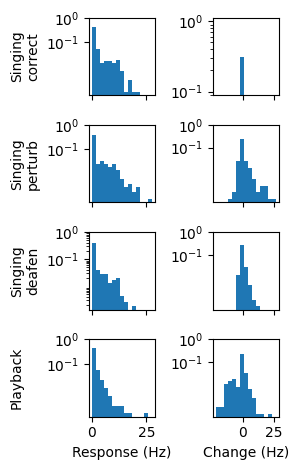

In [30]:
ti, tj = T_burn, int(tsyl_end[0,0])
fig, ax = plot_rate_and_change_dists(tests_all['rE'], test_names, tests_all['rE'][0], ti, tj)
# fig, ax = plot_rate_and_change_dists(rE_block_avgs, test_names, rE_block_avgs[0], ti, tj)